# Методы детекции и сегментации

## Детекция

### Постановка задачи

Дано изображение $I$,хотим найти на этом изображение объекты определенных классов (обозначим их число через $C$). Необходимо выделить прямоугольником объекты всех возможных объектов.

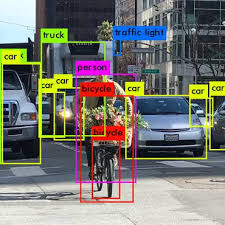


### Метрики качества

https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 - детальный разбор метрик

* IoU (intesection over union). Пусть $A$ - предсказанный bbox, а $B$ - целевой bbox. Тогда

$$
IoU = \frac{|A\cap B|}{|A\cup B|}
$$

Таким образом, можно измерять, насколько похожи между собой предсказанные области


* AP (Average Precision) Для каждого изображения определяем, когда найденные bbox-ы для определенного класса являются TP, TN, FP, FN.

True Positive - когда IoU > 0.5 и класс совпадает
False Positive - когда IoU < 0.5 или нашлось 2 bbox-а с IoU > 0.5 (редко так считают)
False Negative - IoU > 0.5, но класс не совпадает

Далее, для каждого изображения строим Precision-Recall кривую по возрастанию Recall, после чего сглаживаем синюю кривую, как показано на рисунке:

![alt text](https://miro.medium.com/max/1538/1*Uhs5RacJtH3og8tvH5rctQ.png)

AP для каждого класса - это среднее значение Recall в точках 0.0, 0.1, ..., 1.0


mAP - среднее значение AP по всем классам.


* AP at IoU - предыдущая формула, только когда требуется другой уровень IoU (для практических задач - обычно нужна высокая степень пересечения)



### Датасеты для детекции и сегментации

* Pascal VOC (2007, 2012) - первые датасеты по детекции и сегментации изображений. Есть изображения 20 классов, 11500 изображений, разметка при этом достаточно грубая и с объектами высокого размера:

![alt text](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21.jpg)

![alt text](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21_class.png)


* [MSCOCO](mscoco.org): очень много мелких изображений, 90 классов, более точная сегментация и детекция объектов:

![alt text](http://cocodataset.org/images/detection-splash.png)

#### Двустадийные методы детекции

* R-CNN
* Fast-RCNN
* Faster-RCNN
* Mask-RCNN (смесь детекции и сегментации)

#### Одностадийные методы детекции
* YOLO
* SSD
* RetinaNet

### R-CNN


Метод был создан в 2014 году и известен как первый метод применения сверточных нейронных сетей для решения задачи Object Detection.

![alt text](https://miro.medium.com/max/2872/1*Vc3wROtbND2gYD-pi85cPw.png)


1. При помощи метода селективного поиска (аналог методов поиска по изображению), отбиралось порядка 2000 регионов

2. После этого каждый из 2000 регионов подавался на вход предобученной сети AlexNet, получался вектор признаков размера 4096.

3. После обучения сети обучается SVM на необходимое число классов.

4. На этапе inference используется методика non-maximum suppresion, где жадно выбирается объединяющий прямоугольник по метрике IoU.


Дополнительно авторы придумали метод оценки ошибок регрессий, который называется bounding box regression.


Предположим, что предсказанный bbox имеет параметры $(x, y, w, h)$, где $x, y$ - координаты центра bbox, а $w, h$ - их высота и ширина соответственно. Аналогично определим такой же целевой bbox: $(x', y', w', h')$. Каким образом стоит измерять разность между этими bbox-ами?


Оказывается, что необходимо измерять их в относительных масшатабах:

$t_x = \frac{x' - x}{w'}$

$t_y = \frac{y' - y}{h'}$

$t_w = \ln \left( \frac{w}{w'} \right)$

$t_h = \ln \left( \frac{h}{h'} \right)$.

Тогда в каком случае все эти значения равны 0?



## Fast R-CNN

Авторы в 2015 году решили избавиться от медленного SVM и того, что необходимо делать 2000 прогонов на каждое изображение. Поэтому они решили делать прогон для всего изображения сразу!

![alt text](https://miro.medium.com/max/3564/1*y4wLX7KkbmDmRE_YPrelTw.png)


Для того, чтобы такой механизм можно было совершить, используется операция RoI pooling: 

* вычисляем отношение размеров изображения и feature map (сколько это будет для VGG16 и слоя `conv5_3`?)
* делаем масштабирование координат bbox на feature map. ***Вопрос***: если размер исходного изображения равен 800 на 600, то чему будет равен размер feature map в сети VGG16?
* производим операцию вырезания bbox-а для каждого RoI
* далее необходимо привести все RoI к одному размеру при помощи операции max.

![картинка](https://miro.medium.com/max/3000/1*TDOx63GthXwgXJb3hXUsUQ.png)

Приблизительно так это работает, но есть очень много усложнений!

Авторы оригинальной статьи используют выходной размер $7 \times 7$, что означает размер исходного региона должен быть минимум $112 \times 112$, что очень много!

Поэтому предлагается сделать следующий трюк:

* Делаем операцию crop для feature map.
* Делаем resize каждого региона из feature map до размера $14 \times 14$.
* Делаем операцию max pooling с ядром $2 \times 2$.


Как определять классификатор и регрессор:
* Классификатор - если ground truth bbox имеет IoU с регионом больше определенного порога, то ставим класс объекта (при наличии нескольких отдаем предпочтение наибольшему). Иначе - класс "Фон".
* Регрессор - для тех объектов, которые не имеют класс "Фон" (используется индикаторная функция), вычисляется средняя сглаженная функция потерь:

$$
    L(p, u, t^u, v) = L_{cls}(p, u) + \lambda [u \geq 1 ] L_{loc}(t^u, v),
$$

где $L_{cls}$ -- функция log loss, а 

$$
    L_{loc}(t^u, v) = \sum_{i \in x, y, w, h} smooth_{L_1} (t_i^u - v_i)
$$

$$
    smooth_{L_1}(x) = I(|x| \le 1 )(0,5 x^2) + I(|x| > 1)(|x| - 0,5)
$$

Данная функция потерь более устойчива к выбросам относительно $L_2$.

С использованием множества масштабов, получено качество $mAP$ 66.9 % на VOC2007.




### Faster R-CNN

Теперь авторы задумались над тем, чтобы избавиться от метода Selective Search, поскольку он стал узким местом в сети.


Необходимо придумать такой механизм, который позволял бы выделять кандидаты в bbox-ы.

![alt text](https://miro.medium.com/max/1282/1*WO3athE5rXRW76CGbEqk9w.jpeg)

Для этого сделаем ***якори (anchors)*** в каждой точке feature map (опорный bbox)

1. Предположим, что каждая точка feature map является центром определенного якоря
2. Выделим bbox-ы с центром в feature map и размерами $\{ 128^2, 256^2, 512^2 \}$ и отношением сторон $1:1$, $1:2$, $2:1$ (получится 9 якорей).
3. Для каждого из 9 якорей будем предсказывать, является ли якорь подходящим кандидатом для ground truth bbox и насколько его можно "подрегулировать" в терминах $t$, используемых для регрессии.

Рассмотрим пример 9 якорей:

![alt text](https://miro.medium.com/max/1404/1*IS_9HnkfDdF00nID6xxF_A.png)

***Вопрос*** Если имеется изображение размера 800 на 600, то сколько якорей будет получено?

В целом, надо решать эту проблему, поэтому авторы решили сделать задачу фильтрации. Для этого все якори разбиваются на три класса:

* 1 - если он дает максимальный IoU для всех классов в якоре или его IoU с ground truth меньше 0.7.
* -1 - если IoU с ground truth bbox меньше 0.3.
* 0 - иначе - не используется для решения задачи классификации регионов.


Изображение с Region Proposal Network:

![](https://miro.medium.com/max/750/1*JDQw0RwmnIKeRABw3ZDI7Q.png)

Изображение с центрами якорей:


![alt text](https://miro.medium.com/max/1600/1*XEHcNRvRybLzo66F6cn-jg.png)


Далее, после первой части сети отбираются кандидаты следующим образом:

* Происходит сортировка по убыванию уверенности
* Применяется метод Non-Maximum Suppression с показателем IoU выше некоторого порога
* Оставляют top-k кандидатов, с учетом предсказанных координат применяется RoI Pooling, описанный в Fast-RCNN.




## Однопроходные методы

Как было видно, двухпроходные методы имеют недостаток в сложном механизме обучения, поэтому параллельно с этим возникли однопроходные методы, где сразу генерируются anchors.

Рассмотрим те из них, которые дали прорыв.


## YOLO

Ссылка на оригинальную статью - [https://arxiv.org/abs/1506.02640](https://arxiv.org/abs/1506.02640)


Идея: изображение бьется на сетку размера $S \times S$, после чего для ground truth bbox-а определяется ответственная для него ячейка сетки. В каждой ячейке предсказывается $B$ bbox-ов и вероятность того, что ячейка принадлежит данному классу (обозначим их количество через $C$). В итоге, получается $S \times S \times (B * 5 + C)$ выходов, где для каждого bbox-а предсказываются:
* его координаты центра относительно центра клетки
* высота и ширина относительно высоты и ширины изображения соответственно
* вероятность того, что в этой клетке есть ground truth bbox объект.

![](https://miro.medium.com/max/4226/1*OuMJUWo2rXYA-GYU63NUGw.jpeg)



В итоге, функция потерь, измеряет следующие показатели:
* отклонения в вероятности того, что в клетке $i$ есть объект, замеряется доля вмещения относительно IoU
* для клетки с максимальным IoU относительно ground truth - квадратичные отклонения по центру и корни из квадратичных отклонений по высоте и ширине
* отклонения по уверенности объекта, который принадлежит ground truth (для ответственной клетки - показатель в $N$ раз больше)

#### Архитектура сети

Авторы сначала дообучают Inception v1, после чего решают задачу детекции

![](https://miro.medium.com/max/1608/1*jtnrhMFNwGxiQmkY6LkdCQ.jpeg)






## SSD (Single Shot Detector)

Ссылка на оригинальную статью - [https://arxiv.org/abs/1512.02325](https://arxiv.org/abs/1512.02325)


Другим направлением было создание механизма якорей в однопроходном механизме.

Идея заключается в следующем:

* В сверточной сети сразу использовать механизм якорей с предсказанием на выходной слой
* После этого, добавляется $l$ сверточных блоков, в каждом из которых уменьшается размер feature map в 2 раза по каждой из размерностей, после чего уже используется тот же механизм якорей ($l = 5$ у авторов статьи), тем самым базовые положения якорей становятся в 5 раз больше.

![](https://miro.medium.com/max/2508/1*t2oxAKMUMpdKEqI9b1JSLw.png) - архитектура сети по сравнению с YOLO.


Механизм поиска хороших bbox-ов в целом совпадает с идеей из статьи Faster-RCNN.


### Упражнения
1. Напишите механизм переводов bbox из абсолютной шкалы в t-шкалу относительно якоря.
2. Напишите механизм генерации якорей для изображения с шагом stride (по умолчанию, в сети VGG stride = 16)
3. Напишите механизм выбора положительных якорей для ground truth bbox-а.
4. Используя репозиторий https://github.com/machrisaa/tensorflow-vgg и данные Pascal VOC2012 для классов "человек", "кот", "пес", обучите Region Proposal Network.

# Сегментация

## Постановка задачи

### Instance segmentation

Дано изображение $I$, необходимо для каждого пикселя определить, принадлежит он фону (background) или определенному объекту (foreground)

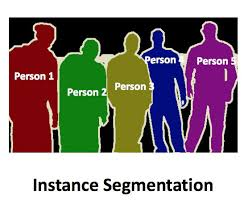


### Semantic Segmentation

Дано изображение $I$, необходимо каждый пиксель изображения соотнести с одним из представленных классов (разбить изображение на классы)

![](https://i2.wp.com/s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/semantic_1.jpg?zoom=2&resize=275%2C183&ssl=1)


***Вопрос*** Какая из задач является частным фоном другой?

***Вопрос*** Какая из метрик, рассмотренных в этой лекции, подходит под решение задачи сегментации? 

## FCN

Ссылка на оригинальную статью - https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf


![](http://deeplearning.net/tutorial/_images/fcn.png)

В самой первой архитектуре - взяли выходы с `pool3` (1/8), `pool4` (1/16), `pool5` (1/32) с сети VGG16, после чего добавили один сверточный слой с 21 фильтром (число классов VOC + класс "фон"), после этого результаты всех слоев суммируется (c приведением к одному масштабу). Приведение к одному масштабу осуществляется методом обратной свертки (conv2d transpose).


Результаты:

![](http://deeplearning.net/tutorial/_images/fcn32_16_8.png)

Как видно, первый метод уже неплохо себя зарекомендовал!



### U-Net

Главная идея U-Net - использование skip connection для сетей для того, чтобы охватывать информацию с feature map:

![](https://miro.medium.com/max/1600/1*OkUrpDD6I0FpugA_bbYBJQ.png)



### Mask R-CNN

Идея аналогична идее Faster-RCNN, только добавляется еще один выход, который занимается решением задачи сегментации для Proposal в духе FCN. Дополнительно, из-за проблем, которые были высказаны в разделе про Fast-RCNN (RoIPool), этот механизм был заменен на RoIAlign (который уже был описан)



### Deeplab

Ссылка на статью Deeplab v1 - https://arxiv.org/pdf/1412.7062.pdf

Основная идея в Deeplab v1 - использовать "atrous convolution", идея которой изображена ниже

![](https://miro.medium.com/max/1220/1*O5B0IRWewitfivGklGDJjA.png)

Тем самым, мы повышаем пространственную мощность сети.

В качестве "feature extractor" сети используется VGG-16 или ResNet-101, где каждый из последовательных слоев заменен на слой с "dilation rate", равным 2.

***Вопрос.*** Каким образом изменяется receptive field у этой сети?


Ссылка на статью Deeplab v2 - https://arxiv.org/pdf/1606.00915.pdf


Идея, которая пришла в Deeplab v2, касается пространственного разрешения признаков, которые подаются на вход классификатору пикселей.

Заметим, что размерность пикселей обычно не учитывает масштаб (к примеру, в VGG-16 кодируется участок мощностью 32 на 32 пикселя, а изображения масок могут иметь различную пространственную связь). Поэтому перед тем, после того, как делается последний max pooling (у него ставится stride = 1, чтобы не терять информацию), разобъем на 4 блока, каждый из которых отвечает за отдельный масштаб (6, 12, 18, 24) - авторы проводят сравнительный анализ подобранных констант.


Сравнение DeeplabV1 и DeeplabV2:

![](https://miro.medium.com/max/1260/1*o3180gQ3t3sDC4mz2nGQsA.png)



Last but not least - в процессе inference для полученных масок используется механизм CRF (conditional random field), в котором минимизируется потенциал по изображению (работает очень долго, в следующих версиях алгоритма не используется).



### Deeplab v3

Ссылка на статью - https://arxiv.org/abs/1706.05587

Новшества - авторы заметили, что не истоит использовать свертки с большим dilation rate - потому что иначе она легко превращается в свертку $1 \times 1$.

Поэтому ASPP выглядит следующим образом:

![](https://miro.medium.com/max/2566/1*8Lg66z7e7ijuLmSkOzhYvA.png)

Где Image Pooling представляет собой следующую структуру:

![](https://miro.medium.com/max/1460/1*dRhGetHArI_bs6IdiIFhkA.png)


Дополнительно авторы решили пересмотреть ширину сети, внедряя технологию MultiGrid - меньше фильтров, больше dilation rate, где в каждом из сверточных слоев блока используется свой вариант (оптимальный оказался равен (1, 2, 1)).

![](https://miro.medium.com/max/2150/1*nFJ_GqK1D3zKCRgtnRfrcw.png)





### Gated SCNN

Концепция state-of-the-art! Параллельно с задачей сегментации решается задача выделения границ (сопряженная задача).

![](https://nv-tlabs.github.io/GSCNN/resources/architecture.jpg)

В основе лежит архитектура Deeplab v3+, обучается крайне долго!

## Задание

Выбрать одну из сетей на сегментацию, представленных выше. Обучить на ней задачу сегментации на датасете Pascal VOC 2012, показать результаты. В качестве стартового кода можно использовать репозиторий tensorflow-vgg или научиться импортировать веса inception в духе, аналогичном tensorflow-vgg.